In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Audio_Files'
#%cd '/content/drive/My Drive/INR/Audio_Files'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/16MAgxWZMal_ia7sxD74LB9D4qSmJb00Q/Audio_Files


In [2]:
import os
import sys
#sys.path.append(os.path.abspath('/userhomes/ishtar/inr_op/Playground/Wire Implementation'))

In [3]:
# %%
#work_dir = "./avishka/audio"
# work_dir = sys.argv[1]
audio_file  =  "gt_bach_reduced_V2.wav"#"gt_bach_reduced.wav" # "chirp.wav" # "pure_sine.wav" # "gt_bach.wav"
# aud_  = sys.argv[2]


In [4]:
# %%
niters = 5000
local_batch_size = 1#8192

learning_rate = 1e-2  # Learning rate
decay_rate = 1e-1# Decay rate

hidden_layers = 3
hidden_features = 256

In [5]:
# %%
import time

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils import clip_grad_norm_

import torchaudio.transforms as transforms

import numpy as np
from tqdm import tqdm
from IPython.display import Audio
import matplotlib.pyplot as plt

from utils import psnr, AudioFile

import torchaudio
import soundfile as sf

In [6]:
# %%
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [7]:
# %%
audio = AudioFile(audio_file)
dataloader = DataLoader(audio, shuffle=False, batch_size=1, pin_memory=True, num_workers=0)
rate, coords, ground_truth = next(iter(dataloader))

coords = coords.cuda()
gt = ground_truth.cuda()
rate = rate[0].item()

Audio(ground_truth.squeeze().numpy(), rate=rate)

print("Rate: ", rate)
print("Coordinates: ", coords.shape)
print("Ground truth: ", gt.shape)


Rate:  44100
Coordinates:  torch.Size([1, 110332, 1])
Ground truth:  torch.Size([1, 110332, 1])


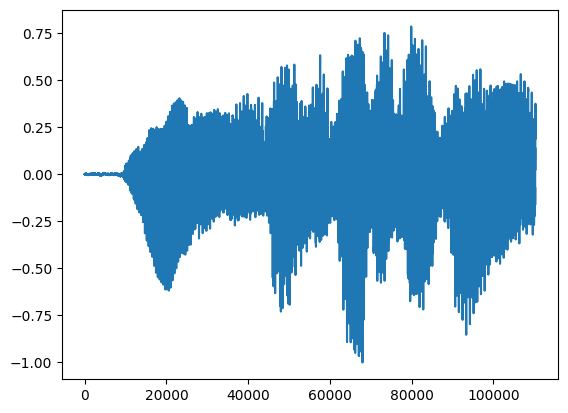

In [8]:
plt.plot( gt.squeeze().cpu().numpy() )
plt.show()

In [9]:
# # %%
# MLP_configs={'task': 'audio',
#              'in_channels': 50,
#              'hidden_channels': [50, 32, 8],
#              'mlp_bias':0.3120,
#              'activation_layer': nn.SiLU,
#              'sample_rate': rate,
#              'GT': gt.squeeze(-1)
#             }

In [10]:
# class MLP(torch.nn.Sequential):
#     '''
#     Args:
#         in_channels (int): Number of input channels or features.
#         hidden_channels (list of int): List of hidden layer sizes. The last element is the output size.
#         mlp_bias (float): Value for initializing bias terms in linear layers.
#         activation_layer (torch.nn.Module, optional): Activation function applied between hidden layers. Default is SiLU.
#         bias (bool, optional): If True, the linear layers include bias terms. Default is True.
#         dropout (float, optional): Dropout probability applied after the last hidden layer. Default is 0.0 (no dropout).
#     '''
#     def __init__(self, MLP_configs, bias=True, dropout = 0.0):
#         super().__init__()

#         in_channels=MLP_configs['in_channels']
#         hidden_channels=MLP_configs['hidden_channels']
#         self.mlp_bias=MLP_configs['mlp_bias']
#         activation_layer=MLP_configs['activation_layer']

#         layers = []
#         in_dim = in_channels
#         for hidden_dim in hidden_channels[:-1]:
#             layers.append(torch.nn.Linear(in_dim, hidden_dim, bias=bias))
#             if MLP_configs['task'] == 'denoising':
#                 layers.append(nn.LayerNorm(hidden_dim))
#             layers.append(activation_layer())
#             in_dim = hidden_dim

#         layers.append(torch.nn.Linear(in_dim, hidden_channels[-1], bias=bias))
#         layers.append(torch.nn.Dropout(dropout))

#         self.layers = nn.Sequential(*layers)
#         self.layers.apply(self.init_weights)

#     def init_weights(self, m):
#         if isinstance(m, nn.Linear):
#             nn.init.trunc_normal_(m.weight, std=0.001)
#             torch.nn.init.constant_(m.bias, self.mlp_bias)

#     def forward(self, x):
#         self.consts = self.layers(x)
#         return self.consts

In [11]:
class RaisedCosineImpulseResponseLayer(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 bias=True,
                 is_first=False,
                 beta0=0.25,
                 T0=0.1,
                 c0=0,
                 eps=1e-10,
                 out_real=False,
                 trainable=False):
        super().__init__()
        self.beta0 = beta0
        self.T0 = T0
        self.c0 = c0
        self.eps= eps
        self.is_first = is_first
        self.out_real = out_real

        self.in_features = in_features
        self.out_features = out_features

        if self.is_first: dtype = torch.float
        else: dtype = torch.cfloat

        # Set trainable parameters if they are to be simultaneously optimized
        self.c0 = nn.Parameter(self.c0*torch.ones(1), trainable)
        self.beta0 = nn.Parameter(self.beta0*torch.ones(1), False)
        self.T0 = nn.Parameter(self.T0*torch.ones(1), trainable)
        self.linear = nn.Linear(in_features, out_features, bias=bias, dtype=dtype)

        # nn.init.uniform_(self.linear.weight, -1/self.in_features, 1/self.in_features)  # Initialize weights (new method)

    def forward(self, input):
        lin = self.linear(input).cuda()
        if not self.is_first:
            lin = lin / torch.abs(lin)# + self.eps)

        f1 = (1 / self.T0) * torch.sinc(lin / self.T0) * torch.cos(torch.pi * self.beta0 * lin / self.T0)
        f2 = 1 - (2 * self.beta0 * lin / self.T0) ** 2 + self.eps  # self.eps is set to 1e-8, to avoid dviding by 0.
        theta = 2 * torch.pi * self.c0 * lin * 1j
        rc = (f1 / f2)


        #if not self.is_first:
        #  rc = rc / torch.abs(rc)
        #print("RC", rc ,  "beta0:",  self.beta0 , "T0:" , self.T0 , "C0:", self.c0 , "eps:" , self.eps  )
        #if self.out_real: return  rc * torch.exp(theta).real
        #else: return rc * torch.exp(theta)#(torch.cos(theta) + 1j * torch.sin(theta))#torch.exp(2*torch.pi*self.c0*lin

        out = rc * torch.exp(theta)

        if not self.is_first:
            out = out / torch.abs(out + self.eps)

        return out.real if self.out_real else out


In [12]:
class INR(nn.Module):
    def __init__(self, in_features,
                 hidden_features,
                 hidden_layers,
                 out_features,
                 outermost_linear=True,
                 first_omega_0=30,
                 hidden_omega_0=30.,
                 beta0=0.25,
                 T0=0.1,
                 c0=0,
                 scale=None,
                 pos_encode=False,
                 sidelength=512,
                 fn_samples=None,
                 use_nyquist=True):
        super().__init__()

        self.nonlin = RaisedCosineImpulseResponseLayer
        dtype = torch.cfloat

        self.net = []
        self.net.append(self.nonlin(in_features,
                                    hidden_features,
                                    beta0=beta0,
                                    T0=T0,
                                    c0=c0,
                                    is_first=True,
                                    trainable=True))

        for i in range(hidden_layers):
            self.net.append(self.nonlin(hidden_features,
                                        hidden_features,
                                        beta0=beta0,
                                        T0=T0,
                                        c0=c0,
                                        trainable=True))

        final_linear = nn.Sequential(nn.Linear(hidden_features, out_features, dtype=dtype),
                                        nn.Sigmoid())
        self.net.append(final_linear)

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        output = self.net(coords)
        return output.real


In [13]:
b0 = 0.05
T0 = 0.5#0.01
c0 = 1#0.05

In [14]:
# %%
model = INR(
    in_features=1,
    out_features=1,
    hidden_features=hidden_features,
    hidden_layers=hidden_layers,
    beta0=b0,
    T0=T0,
    c0=c0)

model.cuda()

optim = torch.optim.Adam(lr=learning_rate, params=model.parameters())
#optim = torch.optim.SGD(lr=learning_rate, params=model.parameters())

scheduler = LambdaLR(optim, lambda x: decay_rate ** min(x / niters, 1))

#warmup = int(0.1 * niters)

'''def lr_fn(step):
    if step < warmup:
        return step / warmup
    t = (step - warmup) / (niters - warmup)
    return 0.5 * (1 + np.cos(np.pi * t))

scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_fn)'''

'def lr_fn(step):\n    if step < warmup:\n        return step / warmup\n    t = (step - warmup) / (niters - warmup)\n    return 0.5 * (1 + np.cos(np.pi * t))\n\nscheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_fn)'

In [15]:
# %%
mse_array = torch.zeros(niters).cuda()
mse_loss_array = torch.zeros(niters).cuda()
consts_ = []
time_array = torch.zeros_like(mse_array)
psnr_vals, step_array, lrs = [], [], []

best_mse = torch.tensor(float('inf'))
best_aud = None

rec = torch.zeros_like(gt)

In [16]:
# %%
init_time = time.time()
tbar = tqdm(range(niters))
# -------------------------------- Training Loop ---------------------------------
for epoch in (tbar):
    batch_size = coords.shape[1]  # Get the total batch size
    half_size = batch_size // local_batch_size  # Process half at a time

    for i in range(0, batch_size, half_size):
        out = model(coords[:,i:i + half_size,:])
        with torch.no_grad(): rec[:,i:i + half_size,:] = out
        loss = ((out - gt[:,i:i + half_size,:])**2).mean()

        optim.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)
        optim.step()

    time_array[epoch] = time.time() - init_time

    with torch.no_grad():
        mse_array[epoch] = ((gt - rec) ** 2).mean().item()
        #consts_.append(model.prior.consts.cpu().detach().numpy())

        psnrval = -10 * torch.log10(mse_array[epoch])
        psnr_vals.append(psnrval.cpu().numpy())

        lrs.append(optim.param_groups[0]['lr'])

        tbar.set_description(f"Loss: {mse_array[epoch]:.6f} "
                     f"| PSNR: {psnrval:.2f}")
        tbar.refresh()

    scheduler.step()

    # Display GT, Reconstructed audio, and Error
    # if epoch % 10 == 0:

    #     fig, axes = plt.subplots(1, 3, figsize=(18, 3))
    #     axes[0].plot(coords.squeeze().detach().cpu().numpy(), gt.squeeze().detach().cpu().numpy())
    #     axes[0].set_ylim(-1, 1)
    #     axes[0].set_title('Ground Truth')
    #     axes[1].plot(coords.squeeze().detach().cpu().numpy(), rec.squeeze().detach().cpu().numpy())
    #     axes[1].set_ylim(-1, 1)
    #     axes[1].set_title('Reconstructed')
    #     axes[2].plot(coords.squeeze().detach().cpu().numpy(), (rec - gt).squeeze().detach().cpu().numpy())
    #     axes[2].set_ylim(-0.6, 0.6)
    #     axes[2].set_title('Error')
    #     plt.show()

    if (mse_array[epoch] < best_mse) or (epoch == 0):
        best_mse = mse_array[epoch]
        best_aud = rec.squeeze().detach().cpu().numpy()
        best_epoch = epoch

Loss: 0.038444 | PSNR: 14.15: 100%|██████████| 5000/5000 [1:15:30<00:00,  1.10it/s]


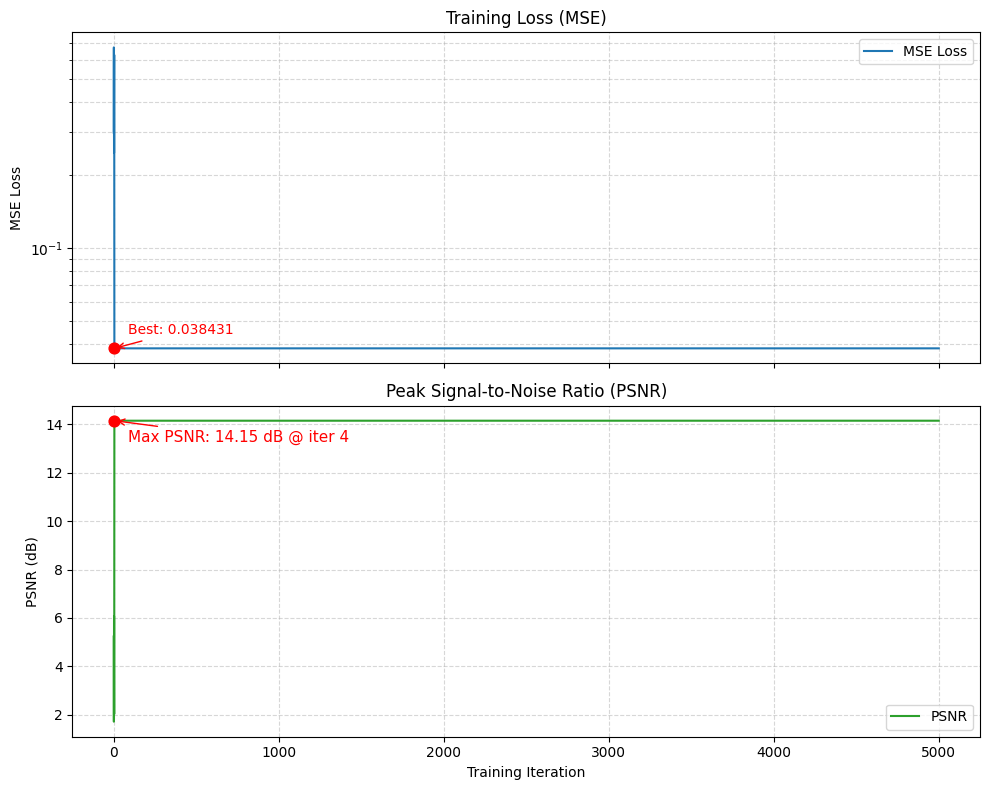

Training Summary:
  • Final MSE : 0.038444
  • Final PSNR: 14.15 dB
  • Best PSNR : 14.15 dB at iteration 4


In [17]:
# ------------------- Load data (from training or checkpoint) -------------------
# If still in memory:
mse_history = mse_array.detach().cpu().numpy()
psnr_history = np.array(psnr_vals)
iterations = np.arange(len(mse_history))

# If loading from saved file:
# checkpoint = torch.load(save_path, map_location='cpu')
# mse_history = checkpoint['mse_array']
# psnr_history = checkpoint['psnr_vals']
# iterations = np.arange(len(mse_history))

# ------------------- Find best values -------------------
best_mse_val = np.min(mse_history)
best_psnr_val = np.max(psnr_history)
best_iter = np.argmax(psnr_history)

# ------------------- Plotting -------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- Loss (MSE) ---
ax1.plot(iterations, mse_history, label='MSE Loss', color='tab:blue', linewidth=1.5)
ax1.scatter(best_iter, best_mse_val, color='red', s=60, zorder=5)
ax1.annotate(f'Best: {best_mse_val:.6f}',
             xy=(best_iter, best_mse_val), xytext=(10, 10),
             textcoords='offset points', color='red', fontsize=10,
             arrowprops=dict(arrowstyle='->', color='red', lw=1))

ax1.set_yscale('log')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Training Loss (MSE)')
ax1.grid(True, which='both', ls='--', alpha=0.5)
ax1.legend()

# --- PSNR ---
ax2.plot(iterations, psnr_history, label='PSNR', color='tab:green', linewidth=1.5)
ax2.scatter(best_iter, best_psnr_val, color='red', s=60, zorder=5)
ax2.annotate(f'Max PSNR: {best_psnr_val:.2f} dB @ iter {best_iter}',
             xy=(best_iter, best_psnr_val), xytext=(10, -15),
             textcoords='offset points', color='red', fontsize=11,
             arrowprops=dict(arrowstyle='->', color='red', lw=1))

ax2.set_xlabel('Training Iteration')
ax2.set_ylabel('PSNR (dB)')
ax2.set_title('Peak Signal-to-Noise Ratio (PSNR)')
ax2.grid(True, ls='--', alpha=0.5)
ax2.legend()

plt.tight_layout()
plt.show()

# ------------------- Print Summary -------------------
print(f"Training Summary:")
print(f"  • Final MSE : {mse_history[-1]:.6f}")
print(f"  • Final PSNR: {psnr_history[-1]:.2f} dB")
print(f"  • Best PSNR : {best_psnr_val:.2f} dB at iteration {best_iter}")

Ground Truth Audio:


Reconstructed Audio:


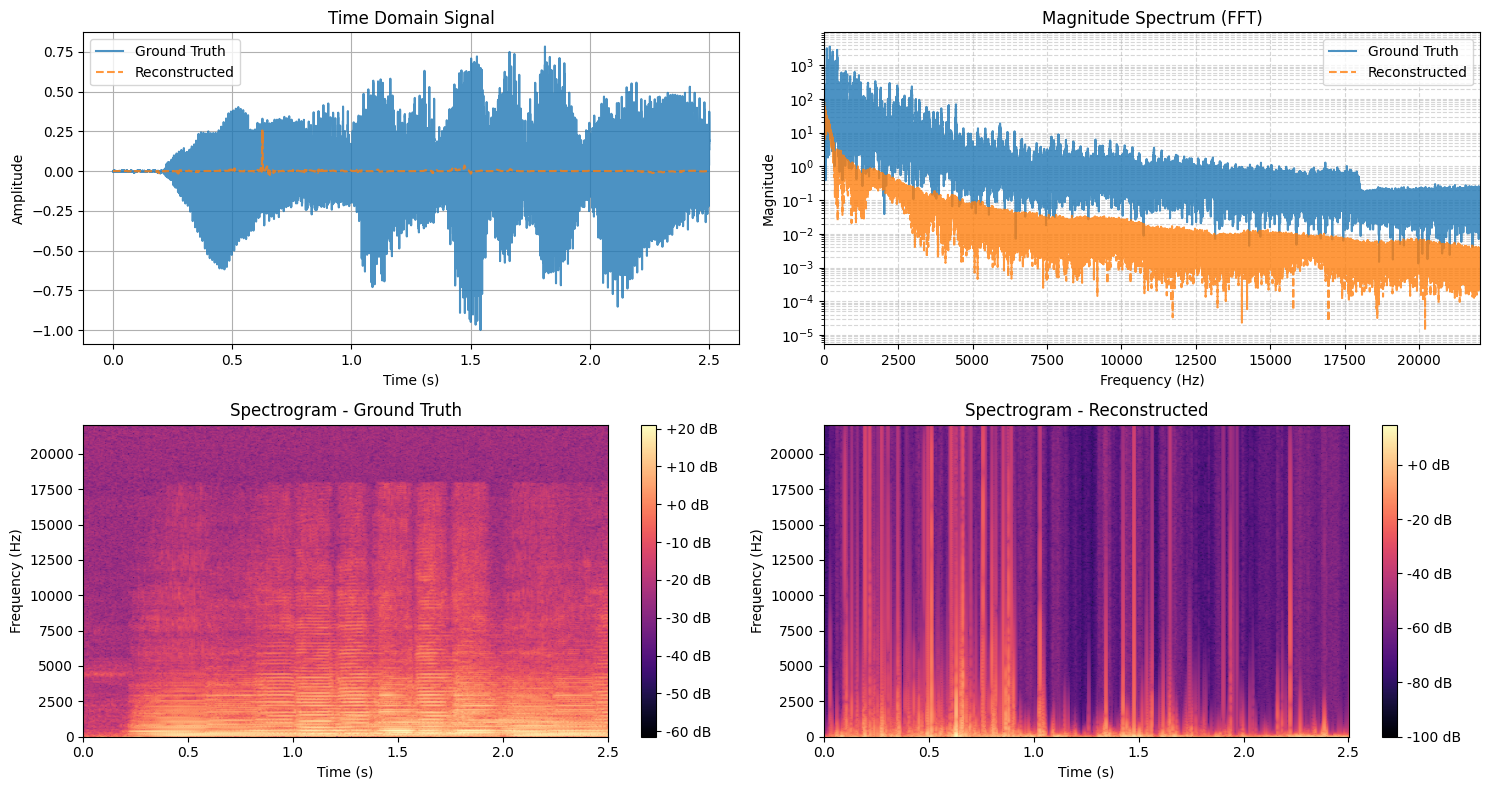

Saved: gt_gt_bach_reduced_V2.wav and rec_T0.5_C1_b0.05.wav


In [18]:
# ------------------- Extract best reconstruction -------------------
# If you have `best_aud` from training:
rec_audio = best_aud  # Shape: (N,)
gt_audio = gt.squeeze().cpu().numpy()  # Shape: (N,)

# If loading from saved file:
# checkpoint = torch.load(save_path, map_location='cpu')
# rec_audio = checkpoint['rec']
# gt_audio = checkpoint['gt']

assert len(rec_audio) == len(gt_audio), "Length mismatch!"

# ------------------- Playable Audio -------------------
print("Ground Truth Audio:")
display(Audio(gt_audio, rate=rate))

print("Reconstructed Audio:")
display(Audio(rec_audio, rate=rate))

# ------------------- Time Domain Plot -------------------
time_axis = np.arange(len(gt_audio)) / rate

plt.figure(figsize=(15, 8))

# Time signal
plt.subplot(2, 2, 1)
plt.plot(time_axis, gt_audio, label='Ground Truth', alpha=0.8)
plt.plot(time_axis, rec_audio, label='Reconstructed', alpha=0.8, linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time Domain Signal')
plt.legend()
plt.grid(True)

# ------------------- FFT (Magnitude Spectrum) -------------------
def compute_fft(signal, sr):
    fft = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(len(signal), 1/sr)
    magnitude = np.abs(fft)
    return freqs, magnitude

freqs_gt, mag_gt = compute_fft(gt_audio, rate)
freqs_rec, mag_rec = compute_fft(rec_audio, rate)

plt.subplot(2, 2, 2)
plt.semilogy(freqs_gt, mag_gt, label='Ground Truth', alpha=0.8)
plt.semilogy(freqs_rec, mag_rec, label='Reconstructed', alpha=0.8, linestyle='--')
plt.xlim(0, rate // 2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum (FFT)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)

# ------------------- Spectrogram -------------------
def plot_spectrogram(signal, sr, ax, title):
    spec = torchaudio.transforms.Spectrogram(
        n_fft=1024,
        win_length=1024,
        hop_length=256,
        power=1.0
    )(torch.from_numpy(signal).unsqueeze(0)).squeeze(0).numpy()

    # Log scale
    spec_db = 10 * np.log10(spec + 1e-10)

    img = ax.imshow(
        spec_db,
        aspect='auto',
        origin='lower',
        extent=[0, len(signal)/sr, 0, sr/2],
        cmap='magma'
    )
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(title)
    plt.colorbar(img, ax=ax, format="%+2.0f dB")

plt.subplot(2, 2, 3)
plot_spectrogram(gt_audio, rate, plt.gca(), 'Spectrogram - Ground Truth')

plt.subplot(2, 2, 4)
plot_spectrogram(rec_audio, rate, plt.gca(), 'Spectrogram - Reconstructed')

plt.tight_layout()
plt.show()

# ------------------- Optional: Save both audios -------------------
sf.write(f"gt_{audio_file}", gt_audio, rate)
sf.write(f"rec_T{T0}_C{c0}_b{b0}.wav", rec_audio, rate)
print(f"Saved: gt_{audio_file} and rec_T{T0}_C{c0}_b{b0}.wav")

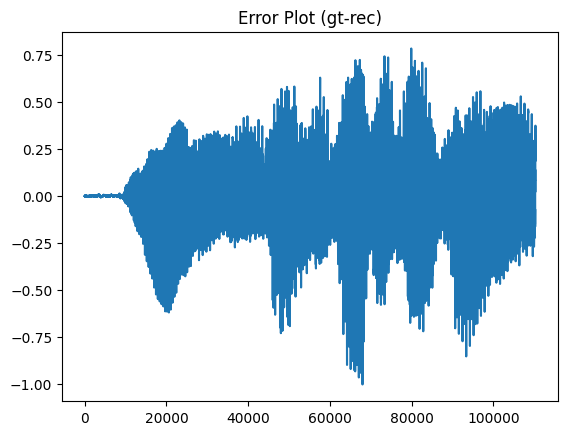

In [19]:
plt.plot(  gt_audio - rec_audio)
plt.title("Error Plot (gt-rec)")
plt.show()

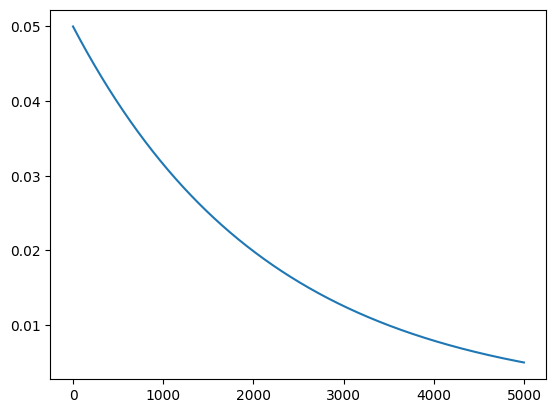

In [20]:
plt.plot( range(len(lrs)),lrs)
plt.show()

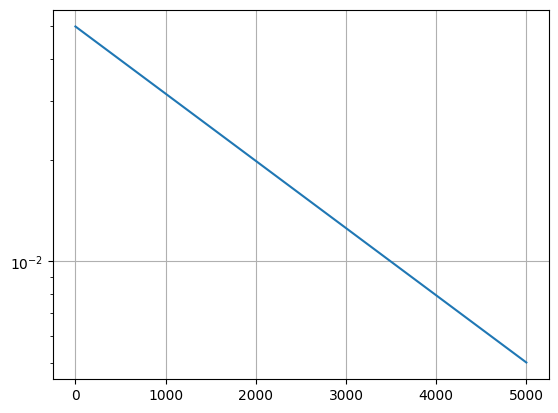

In [21]:
plt.semilogy(range(len(lrs)),lrs)
plt.grid()
plt.show()

In [22]:
# %%
save_path = f"test_save_T0{T0}_C0{c0}_b0{b0}_LR_{learning_rate}.pth"
os.makedirs(f"recon", exist_ok=True)

torch.save({'state_dict': model.state_dict(),
            'best_epoch': best_epoch,
            'gt': gt.squeeze(-1).cpu().numpy(),
            'rec': best_aud,
            'consts_array': np.array(consts_),
            'time_array': time_array.detach().cpu().numpy(),
            'mse_array': mse_array.detach().cpu().numpy(),
            'psnr_vals': np.array(psnr_vals)
            }, save_path)



In [23]:
# %%
# Print maximum PSNR achieved during training
print('--------------------')
print('Max PSNR:', max(psnr_vals))
print('--------------------')

--------------------
Max PSNR: 14.153156
--------------------


In [24]:
#import soundfile as sf

file_name_save = audio_file[2:].split('.')[-2]

sampling_rate = 44100
sf.write(f'{file_name_save}_T0{T0}_C0{c0}_b0{b0}_hidden_f{hidden_features}_hidden_L{hidden_layers}.wav', best_aud, sampling_rate)
print("Audio saved")

Audio saved
